# Adjusting initial conditions

This notebook teaches you how to change the initial conditions of the disk.

First we create a new directory and change to it.

In [1]:
example_name = "301_Adjusting_Inditial_Conditions"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $example_name
    os.chdir(example_name)
print("We are currently in", os.getcwd())

We are currently in /home/rometsch/repo/fargocpt/examples/301_Adjusting_Inditial_Conditions


## Make sure the code is built by running make again.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C ../../src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

117 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp ../config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yamlparser = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yamlparser.load(infile)

In [5]:
# we don't need to run long to inspect the initial conditions
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Ninterm"] = 1 # write a snapshot every orbit
config["Nsnap"] = 1 # wirte 100 snapshots

# use very low resolution by setting it to 2 cell per scaleheight, cps
config["cps"] = 2

# set initial conditions of the powerlaw disk
config["SigmaSlope"] = 1.5 # Sigma(r) = Sigma0 * r**(-SigmaSlope)
config["Sigma0"] = "100 g/cm2" # we can use units here

# also, lets set a different temperature profile via the aspect ratio
config["AspectRatio"] = 0.1

# write out temperature and aspect ratio, so we can plot it
config["WriteTemperature"] = True
config["WriteAspectRatio"] = True

with open(configfile, "w") as outfile:
    yamlparser.dump(config, outfile)

## Run the simulation

In [6]:
import sys
sys.path.append("../../bin")
from fargocpt import run_fargo
configfile = "setup.yml"
run_fargo(2, 1, ["start", configfile], detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmpuxdq_jbq -x OMP_NUM_THREADS=1 /home/rometsch/repo/fargocpt/bin/fargocpt start setup.yml
fargo process pid 735605



Following is an overview widget for the simulation. You can use the slider to scrub through the different snapshots.

Let's see which variables we have.

In [7]:
import disgrid
d = disgrid.Data("output/out")
d.avail()["fluids"]["gas"]["2d"]

['Sigma', 'vrad', 'vtheta', 'energy', 'Temperature', 'aspectratio']

Run the next cell again to refresh the snapshot list.

In [9]:
sys.path.append("../../Tools")
from overview import Overview

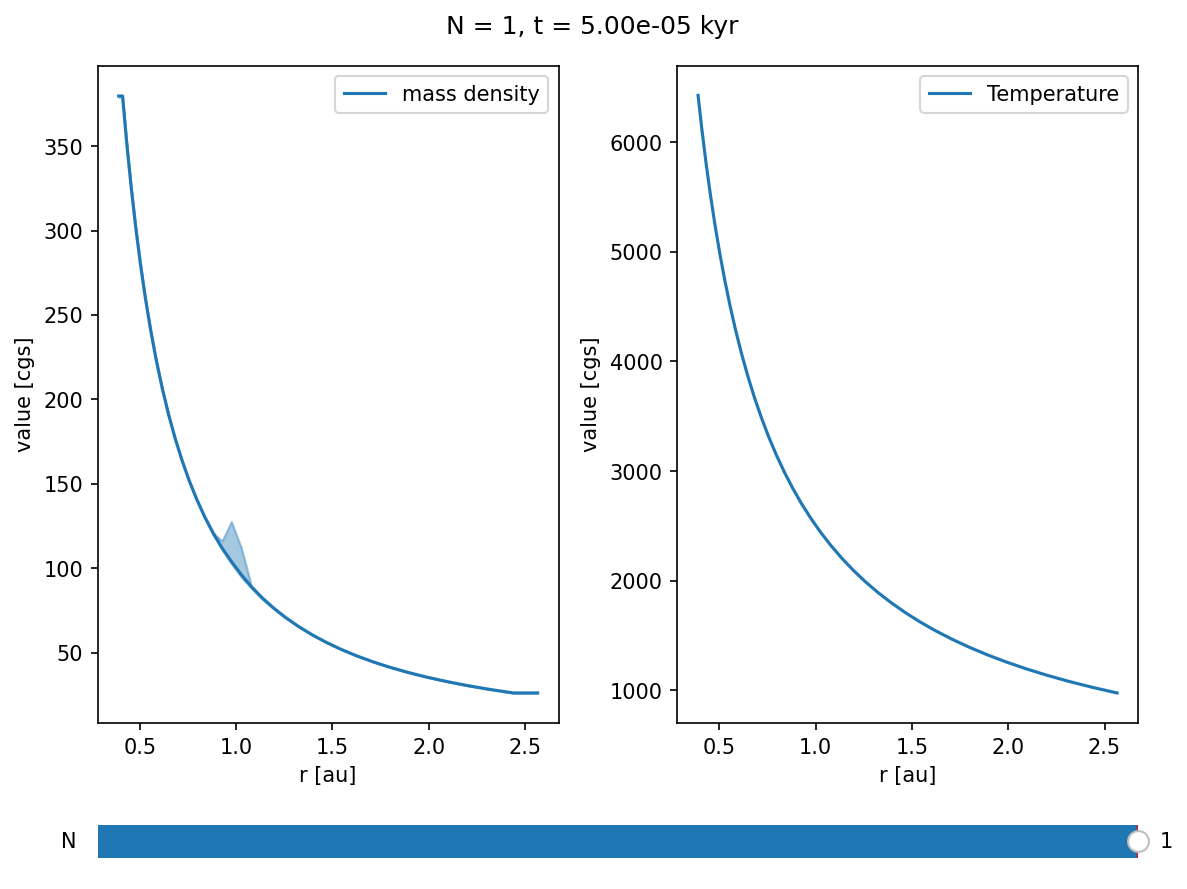

In [11]:
overview = Overview("output/out/", 
                    vars=["1:mass density:minmax",
                          "1:Temperature"])
overview.create();